## CMF 1
Institut für Musikinformatik und Musikwissenschaft – Wintersemester 2025–26
### Woche 09 – Vorlesung

### Zur *Cosine-Similarity*

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def cos_similarity(vector1, vector2):   
    cosine = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
    return cosine

In [7]:
vector1 = np.array([1, 0])
vector2 = np.array([2, 0])
vector3 = np.array([1, 1])
vector4 = np.array([-1, 2])

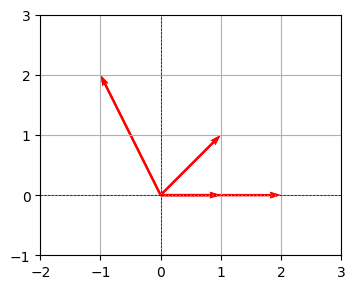

In [8]:
# Plot
vectors = np.array([vector1, vector2, vector3, vector4])

fig, ax = plt.subplots(figsize=(6, 3))
origin = np.zeros((2, 2)) 

for i in range(len(vectors)):
    ax.quiver(*origin, vectors[i, 0], vectors[i, 1], angles='xy', scale_units='xy', scale=1, color='red')

ax.set_xticks(np.arange(-2, 4, 1)) 
ax.set_yticks(np.arange(-1, 4, 1))
ax.grid()
ax.axhline(0, color='black', linewidth=0.5, ls='--')
ax.axvline(0, color='black', linewidth=0.5, ls='--')
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

In [9]:
print(cos_similarity(vector1, vector2))
print(cos_similarity(vector1, vector3))
print(cos_similarity(vector1, vector4))
print(cos_similarity(vector2, vector3))
print(cos_similarity(vector2, vector4))
print(cos_similarity(vector3, vector4))

1.0
0.7071067811865475
-0.4472135954999579
0.7071067811865475
-0.4472135954999579
0.31622776601683794


In [10]:
chord1 = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]) # "reiner" C-Dur-Akkord
chord2 = np.array([0.8, 0, 0, 0, 0.8, 0, 0, 0.8, 0, 0, 0, 0])  # "reiner" C-Dur-Akkord mit anderen Amplituden
chord3 = np.array([1, 0.02, 0.3, 0.05, 0.8, 0.1, 0.02, 0.9, 0.01, 0.01, 0.1, 0.01]) # C-Dur-Akkord mit verschiedenen Amplituden für unterschiedliche Obertöne
chord4 = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0]) # Dominant-Septakkord mit Grundton C
chord5 = np.array([0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0]) # D-Dur-Akkord

In [11]:
print(cos_similarity(chord1, chord2))
print(cos_similarity(chord1, chord3))
print(cos_similarity(chord1, chord4))
print(cos_similarity(chord1, chord5))

1.0
0.9735942612885412
0.8660254037844387
0.0


### Die *Cosine Distance*
Eine solche *Kosinus-Distanz* ist für uns nützlich, da die Librosa-Funktion *dtw* Cost-Matrizen erwartet, die auf einem *Distanz-Maß* beruhen.

In [14]:
def cos_distance(vector1, vector2): 
    cos_dist = 1 - (cos_similarity(vector1, vector2))
    return cos_dist

In [15]:
print(cos_distance(chord1, chord2))
print(cos_distance(chord1, chord3))
print(cos_distance(chord1, chord4))
print(cos_distance(chord1, chord5))

0.0
0.026405738711458793
0.1339745962155613
1.0


### *Dynamic Time Warping* mit Chromagrammen

In [16]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

1) Eine Funktion zur Erstellung von Chrogrammen ausgehen von symbolischen Formaten (siehe Übung 01 der Woche 08):

In [17]:
def symbolic_chromagram(score, frames_per_quarter_note):

    chordified_score = score.chordify()
    # Akkord-Liste des zu analysierenden Scores
    score_chords = list(chordified_score.flatten().getElementsByClass(m21.chord.Chord))

    # Dauer des zu analysierenden Scores (in Viertelnoten ausgedrückt)
    total_duration = int(score_chords[-1].offset + score_chords[-1].quarterLength)

    # Anzahl der Analyse-Frames im Chromagramm
    number_frames_in_chromagram = total_duration*frames_per_quarter_note

    # Initialisierung des Chromagramms als 2-dimensionales Array, das nur Nullen enthält
    chromagram = np.zeros((12, number_frames_in_chromagram))

    # Iterierung über alle Akkorde in der Akkord-Liste
    for chord in score_chords:

        # Start-Frame im Chromagramm für den aktuellen Akkord
        current_chord_offset = chord.offset
        start_in_chromagram = int(current_chord_offset*frames_per_quarter_note)

        # End-Frame im Chromagramm für den aktuellen Akkord
        chord_duration = chord.quarterLength
        end_in_chromagram = int(start_in_chromagram + chord_duration*frames_per_quarter_note)

        # Bestimmung aller im aktuellen Akkord enthaltenen Pitch-Classes
        pitch_classes_current_chord = []
        for note in chord:
            pitch_class = note.pitch.pitchClass
            pitch_classes_current_chord.append(pitch_class)

        # Eintrag des aktuellen Akkords in das Chromagramm
        for time_index in np.arange(start_in_chromagram, end_in_chromagram):

            for pitch_class in pitch_classes_current_chord:
                chromagram[pitch_class, time_index] = chromagram[pitch_class, time_index] + 1
    
    return chromagram

2) Eine Funktion zum Plotten von Chromagrammen:

In [18]:
def plot_chromagram(chromagram):

    plt.figure(figsize=(10, 4))
    plt.imshow(chromagram, aspect='auto', origin='lower', interpolation='none')

    plt.yticks(np.arange(12), ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
    plt.xlabel("Time Frames")
    plt.ylabel("Pitch Classes")
    plt.title("Chromagram")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

3) Eine Funktion zur Erstellung einer *Cost-Matrix* zwischen 2 Chromagrammen:

In [20]:
def cost_matrix(chromagram1, chromagram2):

    lenList1 = chromagram1.shape[1]
    lenList2 = chromagram2.shape[1]

    # Initialisierung der Cost-Matrix 

    CM = np.zeros((lenList1,lenList2))
    for i in range(lenList1):
        for j in range(lenList2):
            CM[i,j] = cos_distance(chromagram1[:,i], chromagram2[:,j])

    

    # Falls die Berechnung einer Cost-Matrix NaN (Not a Number) ergeben sollte, setzen wir den Wert auf 0
    CM[np.isnan(CM)] = 1

    return CM

3) Dynamic-Time-Warping zwischen 2 verschiedenen Aufnahmen des Chopin-Préludes in E-Moll

In [ ]:
...

In [ ]:
...

In [22]:
plt.figure(figsize=(4, 3))
plt.imshow(CM, cmap='binary', origin='lower')
plt.xlabel('Frames')
plt.ylabel('Frames')
plt.colorbar()
plt.show()

NameError: name 'CM' is not defined

<Figure size 400x300 with 0 Axes>

In [ ]:
...

In [21]:
warping_path = np.array(warping_path) 
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(CM, cmap='gray_r', origin='lower', aspect='equal')
plt.plot(warping_path[:, 1], warping_path[:, 0], marker='o', color='r')
plt.clim([0, np.max(CM)])
plt.colorbar()
plt.title('Optimal warping path on CM')
plt.xlabel('Chromagram2')
plt.ylabel('Chromagram1')

plt.subplot(1, 2, 2)
plt.imshow(ACM, cmap='gray_r', origin='lower', aspect='equal')
plt.plot(warping_path[:, 1], warping_path[:, 0], marker='o', color='r')
plt.clim([0, np.max(ACM)])
plt.colorbar()
plt.title('Optimal warping path on ACM')
plt.xlabel('Chromagram2')
plt.ylabel('Chromagram1')

plt.tight_layout()

NameError: name 'warping_path' is not defined

### Berechnung einer Tempo-Kurve mihilfe von Dynamic-Time-Warping

In [40]:
import librosa
import music21 as m21
import numpy as np
import matplotlib.pyplot as plt

1) Erstellung des Chromagramms der MusicXML-Datei *chopin_score_beginning.musicxml*:

In [ ]:
...

2) Dynamic-Time-Warping zwischen MusicXML-Chromagramm und Audio-Chromagramm:

In [ ]:
...

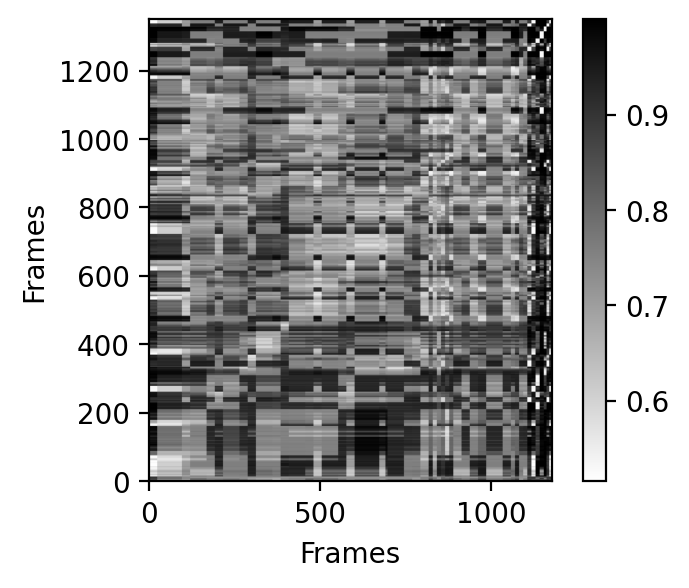

In [162]:
plt.figure(figsize=(4, 3))
plt.imshow(CM_Tempo_Curve, cmap='binary', origin='lower')
plt.xlabel('Frames')
plt.ylabel('Frames')
plt.colorbar()
plt.show()

In [ ]:
...

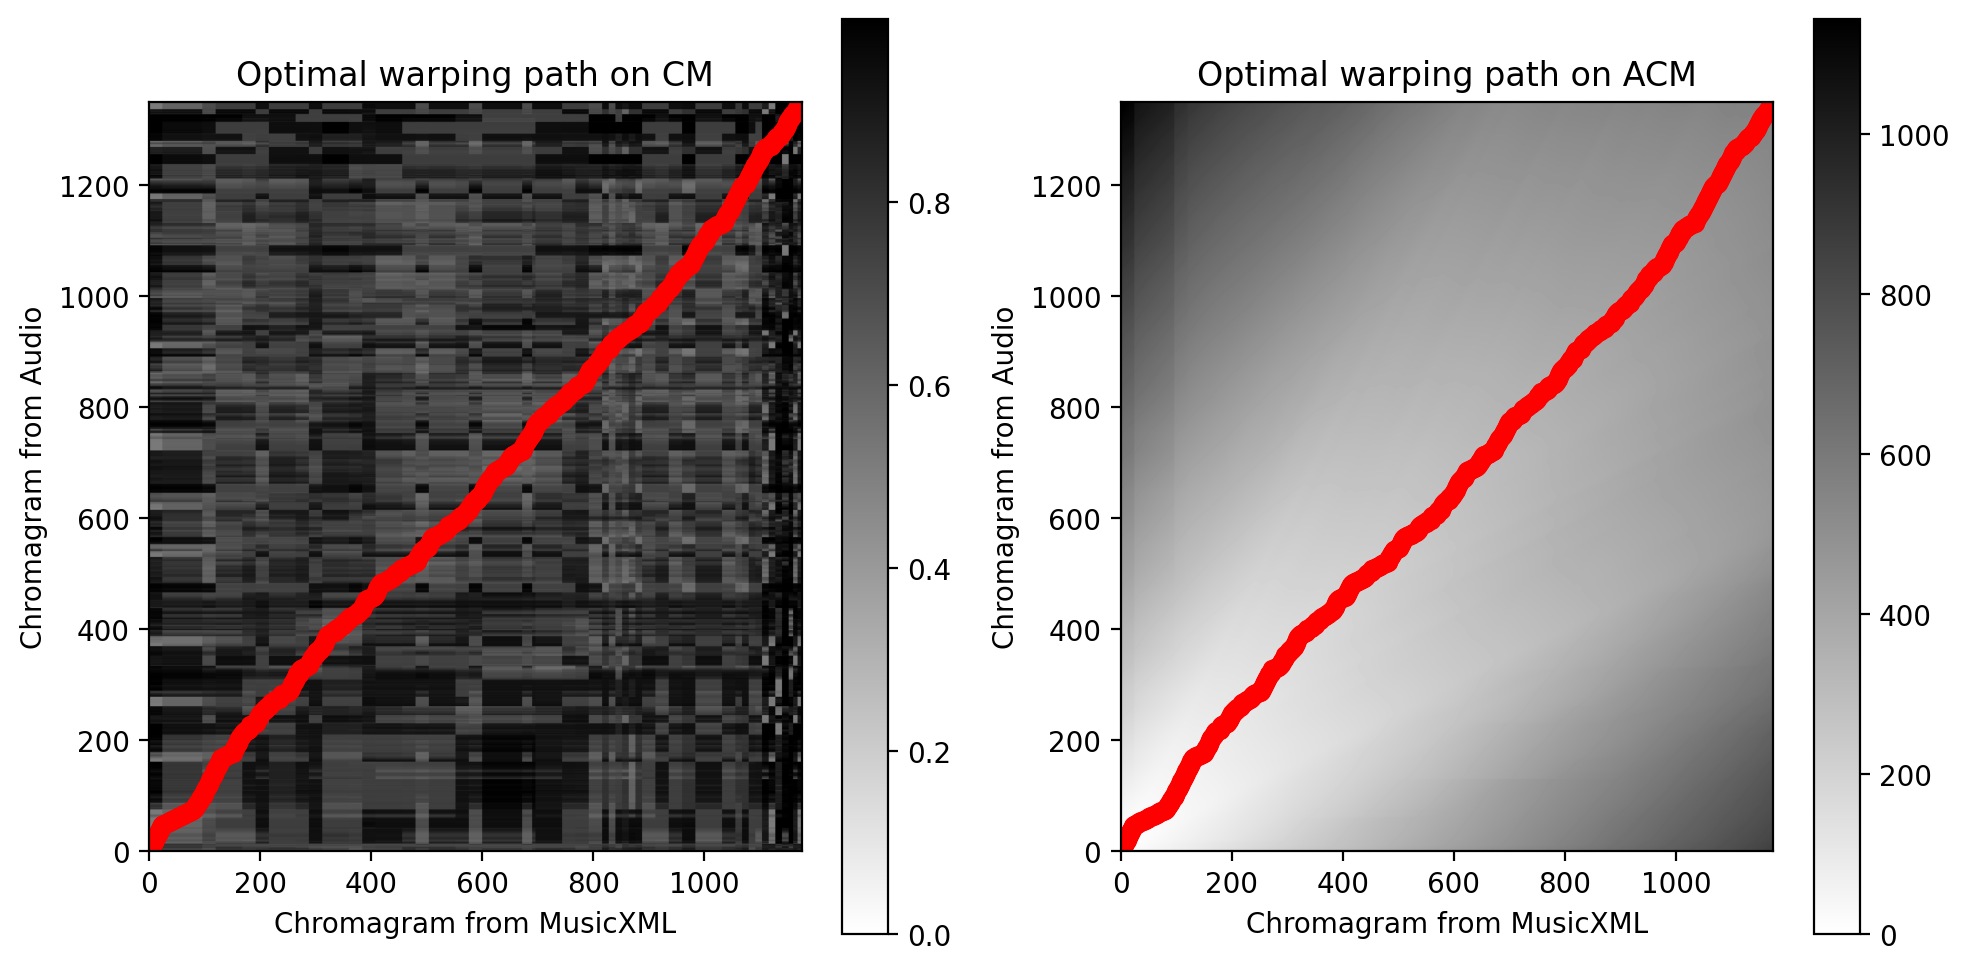

In [164]:
warping_path_Tempo_Curve = np.array(warping_path_Tempo_Curve) 
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(CM_Tempo_Curve, cmap='gray_r', origin='lower', aspect='equal')
plt.plot(warping_path_Tempo_Curve[:, 1], warping_path_Tempo_Curve[:, 0], marker='o', color='r')
plt.clim([0, np.max(CM_Tempo_Curve)])
plt.colorbar()
plt.title('Optimal warping path on CM')
plt.xlabel('Chromagram from MusicXML')
plt.ylabel('Chromagram from Audio')

plt.subplot(1, 2, 2)
plt.imshow(ACM_Tempo_Curve, cmap='gray_r', origin='lower', aspect='equal')
plt.plot(warping_path_Tempo_Curve[:, 1], warping_path_Tempo_Curve[:, 0], marker='o', color='r')
plt.clim([0, np.max(ACM_Tempo_Curve)])
plt.colorbar()
plt.title('Optimal warping path on ACM')
plt.xlabel('Chromagram from MusicXML')
plt.ylabel('Chromagram from Audio')

plt.tight_layout()

3) Berechnung einer Tempo-Kurve:

In [ ]:
...

[[1349 1175]
 [1347 1174]
 [1345 1173]
 ...
 [   4    2]
 [   2    1]
 [   0    0]]
